## Final Project Submission

Please fill out:
* Student name: Christopher Hollman
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL: https://medium.com/@chollman91/daiquiris-dislocations-and-data-changing-careers-at-30-e8529dad5f97


# Project Overview
 Microsoft has decided to venture into film making. They have chosen to use a data driven approach to ensure a successful entry into the industry. This project aims to look at existing data from recent films and develop a plan to
maximize the profit and success of Microsoft's new production company. 


In [1]:
##importing necessary tools
import pandas as pd
import seaborn as sns
import numpy as np
import os
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches


In [2]:
## importing files 

csv_files = glob("./zippedData/*.csv.gz")
csv_files

csv_files_dict = {}
for filename in csv_files:
    filename_cleaned = os.path.basename(filename).replace(".csv", "").replace(".", "_")
    filename_df = pd.read_csv(filename, index_col=0)
    csv_files_dict[filename_cleaned] = filename_df
rt_info = pd.read_csv("zippedData/rt.movie_info.tsv.gz", delimiter='\t')
rt_reviews = pd.read_csv("zippedData/rt.reviews.tsv.gz", delimiter='\t',encoding="latin1")
imdb_title_basics = csv_files_dict["imdb_title_basics_gz"]
tn_movie_budgets = csv_files_dict["tn_movie_budgets_gz"]

In [3]:
##merging datasets for interpretation

rt_combined = rt_info.merge(rt_reviews, how="inner",on="id")
title_and_budget = tn_movie_budgets.merge(
    imdb_title_basics, how="inner", left_on = "movie", right_on = "primary_title")


## Rotten Tomatoes Data:
This is the dataset we will use to determine which directors tend to generate positive reviews. Our main columns of interest are "director", "top_critic" and "fresh"

In [4]:
rt_combined.head()

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,review,rating_y,fresh,critic,top_critic,publisher,date
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


## The Numbers/IMDB data:
This is the dataset we will use to calculate financial numbers based on genre and release date. Our columns of interest should be relatively obvious.

In [5]:
title_and_budget.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,original_title,start_year,runtime_minutes,genres
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",Avatar,Abatâ,2011,93.0,Horror
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy"
2,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi"
3,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi"
4,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi"


# Data Preparation:
## Data Cleaning
At this stage I began dropping rows that were not relevant the data I wanted to analyze.

In [6]:
##Dropping irrelevant columns from Rotten Tomatoes data

rt_combined.drop(columns = ["synopsis", "theater_date","dvd_date", "studio",
    "runtime","review"], inplace=True)
## dropping reviews not given by "top critics"
rt_top_critics = rt_combined[rt_combined["top_critic"] !=0].dropna()


In [7]:
##limiting new dataset to only 50 most reviewed directors

directors_sorted = rt_combined["director"].value_counts(ascending=False).to_frame()
top_50_directors = directors_sorted[:50]

top_50_directors = top_50_directors.reset_index().rename(
    columns={"index":"director","director":"rating_count"})

In [8]:
##inner merge with original dataset
##resulting dataset is complete data for top 60 directors

top_directors_reviews = top_50_directors.merge(rt_top_critics)
director_ratings = top_directors_reviews.groupby(["director","fresh"]).count()
director_ratings = director_ratings["rating_count"].unstack("fresh")

##creating new columns for total ratings and percetages for fresh and rotten ratings
director_ratings["review_total"] = director_ratings[
    'fresh'] + director_ratings['rotten']

director_ratings["fresh_pct"] = director_ratings["fresh"]/director_ratings[
    "review_total"]*100
director_ratings["rotten_pct"] = director_ratings["rotten"]/director_ratings[
    "review_total"]*100
top_15_directors = director_ratings.sort_values("fresh_pct", ascending=False)[:15]



##creating list of top 15 director in terms of percentage of postive reviews

top_15_directors = top_15_directors.sort_values('fresh_pct')

In [9]:
## dropping redundant and unneccessary columns from second data set

title_and_budget.drop(columns=[
    "start_year", 
    "movie", 
    "original_title"], inplace=True)

In [10]:
##stripping characters and converting strings to integers 

title_and_budget["production_budget"] = title_and_budget[
    "production_budget"].str.replace("$","").str.replace(",","").astype(int)

title_and_budget["domestic_gross"] = title_and_budget[
    "domestic_gross"].str.replace("$","").str.replace(",","").astype(int)

title_and_budget["worldwide_gross"] = title_and_budget[
    "worldwide_gross"].str.replace("$","").str.replace(",","").astype(int)


In [11]:
##filtering out production budgets below mean of dataset

title_and_budget = title_and_budget[
    title_and_budget["production_budget"] >= 16_000_000]

In [12]:
##converting release dats to datetime format and isolating month as ordered string
months = ["Jan", "Feb", "Mar", "Apr","May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
title_and_budget["release_date"] = pd.to_datetime(
    title_and_budget["release_date"])
title_and_budget["release_month"] = title_and_budget['release_date'].dt.strftime("%b")
title_and_budget["release_month"] = pd.Categorical(
    title_and_budget["release_month"], ordered=True, categories=months)


## Feature Engineering
At this stage I create new columns for profit and ROI for the IMDB/The Numbers dataset. Some further data cleaning is needed to separate out individual genres.

In [13]:
##new columns for profit and ROI

title_and_budget["profit"] = title_and_budget[
    "worldwide_gross"] - title_and_budget["production_budget"]

title_and_budget["ROI"] = title_and_budget[
    "profit"]/title_and_budget["production_budget"]*100


In [14]:
##dropping 0 values to avoid skewing data

title_and_budget = title_and_budget[title_and_budget["production_budget"] !=0]
title_and_budget = title_and_budget[title_and_budget["domestic_gross"] !=0]
title_and_budget = title_and_budget[title_and_budget["worldwide_gross"] !=0]

In [15]:
##converting genre from single string to list for further organization 

title_and_budget["genres"] = title_and_budget["genres"].str.split(",")

In [16]:
##exploding genres to calculate mean values for each genre

title_budget_exploded = title_and_budget.explode("genres")


In [17]:
##checking for small sample sizes to exclude from list

title_budget_exploded.value_counts("genres")

genres
Drama          784
Action         491
Comedy         460
Adventure      380
Thriller       279
Crime          212
Documentary    200
Romance        154
Sci-Fi         139
Fantasy        138
Horror         136
Biography      124
Animation      119
Family         108
Mystery        105
History         49
Sport           36
Music           32
War             23
Musical         17
Western         13
News             4
dtype: int64

In [18]:
##excluding genres with small sample sizes
counts = title_budget_exploded["genres"].value_counts()

title_budget_exploded = title_budget_exploded[
    ~title_budget_exploded["genres"].isin(counts[counts < 50].index)]

In [19]:
##grouping values by genre and month for graphing
genres_ROI = title_budget_exploded.groupby(
    "genres").mean().sort_values("ROI", ascending=False)

genres_profit=title_budget_exploded.groupby(
    "genres").mean().sort_values("profit", ascending=False)

months_grouped = title_and_budget.groupby(
    "release_month").mean().sort_values("worldwide_gross", ascending=False)
months_grouped = months_grouped.filter(
    ["domestic_gross","worldwide_gross"], axis=1)


# Analysis:

## Box Office Gross:
The average film has a domestic gross of 70.9 million USD and a worldwide gross of 171.5 million. The highest earning films go as high as 114.1 million domestic gross and 293.6 million worldwide gross

In [20]:
months_grouped.describe()

,domestic_gross,worldwide_gross
count,1.200000e+01,1.200000e+01
mean,7.090553e+07,1.715626e+08
std,2.831056e+07,7.558355e+07
min,3.629165e+07,7.779592e+07
25%,4.555140e+07,1.046154e+08
50%,6.691226e+07,1.590120e+08
75%,9.169611e+07,2.254495e+08
max,1.141824e+08,2.936119e+08


## Plotting Release Date Data:
Below is a graph of average domestic and worldwide gross earnings by month for movies made between 2010 and present day. As you can see particularly with worldwide earnings, there is a significant difference between the highest months and the lowest (roughly triple). Earnings tend to peak in May and stay high through July. There are secondary peaks in March and November/December. 

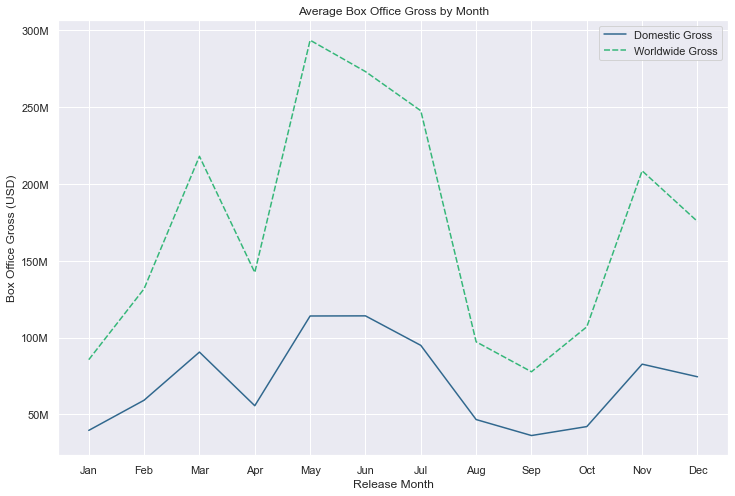

In [21]:
##plotting average domestic and worldwide gross by month
sns.set(rc={"figure.figsize":(12, 8)}) 
sns.set_theme(style="darkgrid")
x1 = sns.lineplot(data=months_grouped, palette="viridis")
x1.set(
    xlabel="Release Month",
    ylabel="Box Office Gross (USD)",
    title="Average Box Office Gross by Month")
plt.legend(labels=["Domestic Gross","Worldwide Gross"])
;
x1.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: "{:,.0f}".format(x/1000000) + "M"))


## Plotting ROI by  Genre:
Below is a horizontal bar plot representing average return on investment(ROI) based on genre. The top categories are Animation, Fantasy, Family, Sci-Fi, and Adventure, which also make up the top 5 in profitability, albeit in a slightly different order. This suggests that focusing on these genres would tend to generate higher earnings. 

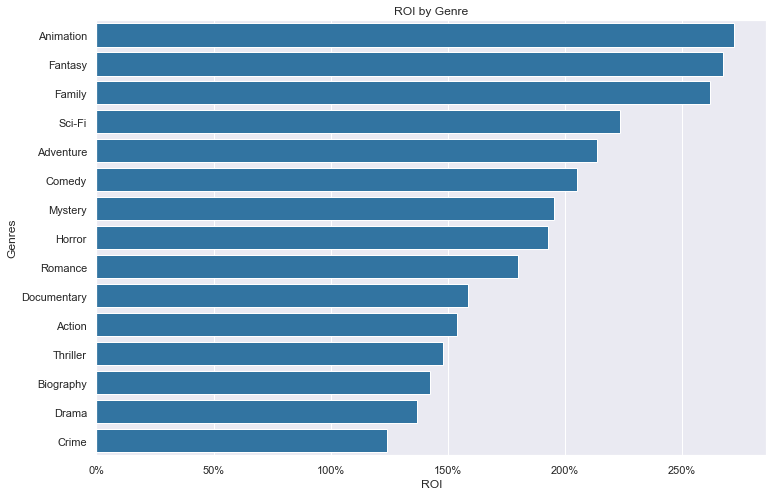

In [22]:
##plotting average ROI of by genre

sns.set(rc={"figure.figsize":(12, 8)}) 
sns.set_theme(style="darkgrid")
x2=sns.barplot(
    y = genres_ROI.index, x="ROI", 
    color = "tab:blue",
    data = genres_ROI, orient="h")
x2.set(
    ylabel="Genres", title = "ROI by Genre")
x2.xaxis.set_major_formatter(mtick.PercentFormatter());


## Plotting Profit by Genre
Next is a graph with somewhat similar findings. Action movies in particular perform better using this metric, but suffer from tending to have higher production cost, which is more emphasized in ROI. 

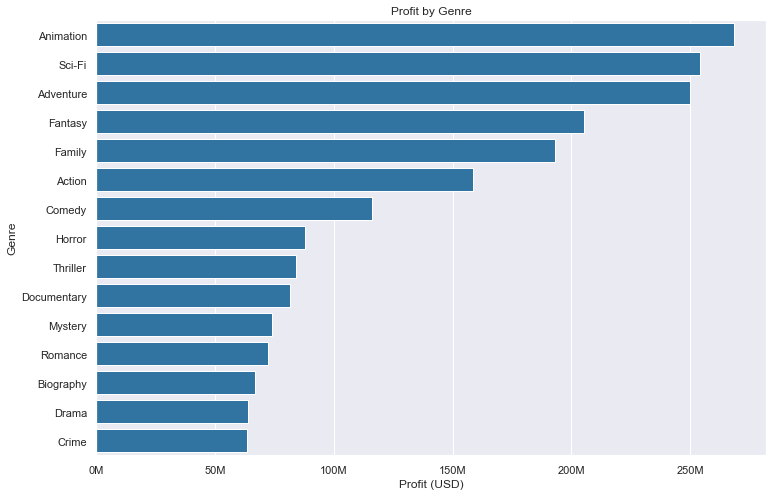

In [23]:
##plotting average profit(worldwide gross-production budget) by genre
sns.set(rc={"figure.figsize":(12, 8)})
sns.set_style("darkgrid")
x3=sns.barplot(
    y=genres_profit.index, 
    x="profit",
    color="tab:blue",
    data=genres_profit, 
    orient="h")
x3.set(
    xlabel="Profit (USD)",
    ylabel="Genre",
    title="Profit by Genre")
x3.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: "{:,.0f}".format(x/1000000) + "M"));

## Plotting Director Review Data:
Finally here is a stacked bar plot depicting positive("Fresh") and negative("Rotten") reviews from top critics. The plot is currently ordered by highest ratio of fresh to rotten reviews, top to bottom. Any of these directors would be an excellent target to approach for Microsoft's movies, as the tend to generate to most positive sentiment from highly regarded film critics.

''

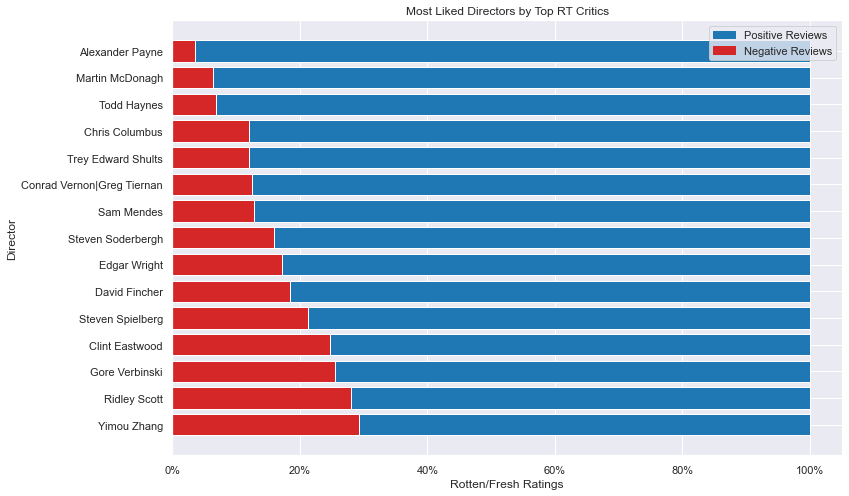

In [24]:
##plotting top 15 directors by # of "fresh" ratings per "rotten" rating
sns.set(rc={"figure.figsize":(12, 8)})
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(
    top_15_directors.index,
    top_15_directors['fresh_pct'],
    left=top_15_directors['rotten_pct'],
    color='tab:blue'
    )
ax.barh(
    top_15_directors.index,
    top_15_directors['rotten_pct'],
    color="tab:red")

ax=ax
ax.set(
    ylabel="Director", xlabel="Rotten/Fresh Ratings",
    title="Most Liked Directors by Top RT Critics")

top_bar = mpatches.Patch(color='tab:blue', label='Positive Reviews')
bottom_bar = mpatches.Patch(color='tab:red', label='Negative Reviews')

plt.legend(handles=[top_bar, bottom_bar])

ax.xaxis.set_major_formatter(mtick.PercentFormatter());

;

## Conclusions:
**This data points toward three suggestions for Microsoft as they prepare for entry into the film industry.**

1) Focus on films that fall into the more lucrative genres. 

2) Approach one of the top 15 directors to produce films.

3) Release high budget movies in May through July. Smaller budget films could also be released in March or November.
    

# Next Steps:
1) Further insight into secondary film earnings, such as popularity on streaming services. This would lead to a clearer picture of a films overall profitability.

2) Similar analysis of writers and actors. Small tweaks to the code could generate a list of other film professionals that are likely to generate positive reviews from top critics.

3) A focused study on films that performed poorly. This could uncover some trends and give insight on what to avoid in order to maintain a profitable studio with a reputation for producing quality films.